# Home Credit - Credit Risk Model Stability Project

## Abstract

The goal of this project is to accurately predict which clients are likely to default on their loans. Loan defaults pose significant financial risks to consumer finance providers, impacting their profitability and stability. Traditional methods of assessing default risk often rely on historical data and conventional credit scoring models, which may not fully capture the complexities of an individual's financial behavior over time. By leveraging advanced machine learning techniques, this project seeks to develop more reliable and robust models for predicting loan defaults.

This endeavor is crucial as it offers consumer finance providers a tool to better assess the risk associated with potential clients, leading to more informed lending decisions. Improved prediction models can help reduce the incidence of loan defaults, thereby enhancing the financial health of lending institutions. Additionally, stable and accurate risk assessments can contribute to fairer lending practices, as they are likely to identify creditworthy clients who might be overlooked by traditional methods. This project not only aims to enhance the accuracy of default predictions but also emphasizes the importance of model stability over time, ensuring that the solutions are sustainable and effective in the long run.

### Accomplishments:

1. Ability to work with highly imbalanced data and perform different types of missing value imputations to enhance model performance:
    A significant discovery during our investigation was the profound impact that missing value imputation had on model performance. Given that approximately 92% of our dataset contained missing values, robust imputation strategies were essential(mean and mode imputation, knn imputation, binary indicators) significantly improved the model's ability to handle incomplete data.
    This approach not only filled the gaps in the dataset but also provided additional signals that the model could leverage to make more accurate predictions.
2. Effectivenes of SMOTE in addressing class imbalance:
    By generating synthetic samples for the minority class, SMOTE significantly improved the recall of the minority class predictions without overly compromising precision. This balancing act was pivotal in ensuring that the model could identify true positives more reliably. Our iterative evaluation showed a substantial increase in the recall metric, indicating that the model became much better at identifying positive instances in the imbalanced dataset.

## Introduction

Our project aims to develop a robust model for predicting loan defaults using a highly imbalanced dataset from a Kaggle competition hosted by Home Credit ([link](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/overview)). This dataset includes over 1.5 million cases with a binary target variable indicating default (positive class) or no default (negative class). The data spans various financial and socio-economic features, sourced from multiple tables, with a significant imbalance (97% no default, 3% default) and a high percentage of missing values (92%). The primary research question is: Can we create a stable, accurate predictive model that effectively identifies clients likely to default on loans?

### Importance and Research Plan
Predicting loan defaults accurately is crucial for financial institutions as it directly impacts their risk management strategies and financial stability. Improved prediction models can reduce financial losses and help institutions make more informed lending decisions, ultimately contributing to a healthier financial ecosystem.

#### Key Results

Key results include significant improvements in precision and recall metrics by using the LightGBM model. This demonstrates our model’s enhanced ability to identify true positive cases of loan defaults, despite the challenges posed by the dataset's imbalance and missing values.

## Background

Credit risk refers to the potential loss that lenders face when borrowers fail to repay loans or meet contractual obligations. Traditionally, this means the borrower does not make the agreed-upon loan payments, leading to financial loss for the lender. This risk is crucial in the financial industry, especially for banks and lenders, as it directly affects their profitability and sustainability. Assessing credit risk is essential for lenders, including banks and consumer finance companies, as they evaluate the likelihood that a borrower may default on loan obligations. This assessment involves analysing the borrower's financial history, current financial status, and other socio-economic factors. A high credit risk indicates a higher probability of default, potentially resulting in financial losses for the lender due to unpaid loan principal and interest.

#### Current State of Credit Risk Prediction Models
The landscape of credit risk prediction has evolved significantly with the advent of big data, machine learning, and artificial intelligence technologies. Modern credit risk models have become more sophisticated, integrating various data sources and employing advanced algorithms to improve prediction accuracy. Here are some of the state-of-the-art methods and innovations in current credit risk prediction models:

•	***Machine Learning Models:*** Algorithms such as random forests, gradient boosting machines (GBMs), and neural networks have been successful in predicting credit risk by learning complex patterns in data.

•	***Deep Learning Models:*** More complex models, like deep neural networks, have been explored for their ability to process vast amounts of unstructured data, providing insights from data points traditional models might miss.

•	***Alternative Data Sources:*** Modern credit risk models incorporate non-traditional data, such as mobile phone usage, social media activity, and even psychometric tests, to gauge a borrower's creditworthiness, especially useful for those with little to no traditional credit history.


#### Key Features in Credit Risk Prediction

Certain features are particularly indicative of a borrower's likelihood to default, including:

•	***Credit History:*** A borrower's past behaviour with credit, including payment history, credit utilization, and the age of credit accounts.
•	***Income Level and Stability:*** Regular and verifiable income sources are strong indicators of a borrower's ability to repay loans.
•	***Debt-to-Income Ratio:*** This measures how much of a borrower's income is used to service existing debt, indicating the capacity to take on and repay new debt.
•	***Employment Status:*** Employment stability and the nature of a borrower's job can influence their risk profile.
•	***Socio-Economic Factors:*** Factors such as education level, marital status, and homeownership can also play a role in credit risk assessment.

#### References in Credit Risk:

Amir E. Khandani, Adlar J. Kim, Andrew W. Lo, Consumer credit-risk models via machine-learning algorithms, Journal of Banking & Finance, Volume 34, Issue 11, 2010, Pages 2767-2787, ISSN 0378-4266, https://doi.org/10.1016/j.jbankfin.2010.06.001 
(https://www.sciencedirect.com/science/article/pii/S0378426610002372)

Noriega, Jomark & Rivera, Luis & Herrera, Jose. (2023). Machine Learning for Credit Risk Prediction: A Systematic Literature Review. 10.20944/preprints202308.0947.v1.
(https://www.researchgate.net/publication/373108628_Machine_Learning_for_Credit_Risk_Prediction_A_Systematic_Literature_Review)

Dongqi Yang, Binqing Xiao, Mengya Cao, Huaqi Shen, A new hybrid credit scoring ensemble model with feature enhancement and soft voting weight optimization, Expert Systems with Applications,
Volume 238, Part C, 2024, 122101, ISSN 0957-4174, https://doi.org/10.1016/j.eswa.2023.122101.
(https://www.sciencedirect.com/science/article/pii/S0957417423026039)

## Data

As stated above, our dataset comes from the Kaggle Competition - Credit Risk Model Stability hosted by Home Credit, an international consumer finance provider. The data can be obtained by downloading from the Kaggle website ([link](https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data)) or entering the command line (install Kaggle first):
```bash
kaggle competitions download -c home-credit-credit-risk-model-stability
```

The dataset is spread across 17 tables (1 base table + 16 data tables). It is split between training data with over 1.5 million cases, and testing data with 10 cases and no target labels. Our training and testing sets were taken from the training data provided as the test set could not provide us with any evaluation metrics and was too small.

In [1]:
# Directory to data
data_root = '../data/raw/csv_files/train'

### Base Table

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization functions
import utils.viz_tools as viz_tools

warnings.filterwarnings('ignore')

In [3]:
base_table = 'train_base.csv'
base_df = pd.read_csv(os.path.join(data_root, base_table))
base_df['date_decision'] = pd.to_datetime(base_df['date_decision'])

With the base table we can inspect the composition of the classes. A class imbalance of 97-to-3 in favor of the negative case (no default) is a very imbalanced dataset.

In [4]:
# Total cases
n_total = len(base_df)

# Number of negative cases
n_neg = len(base_df[base_df['target'] == 0])

# Number of positive cases
n_pos = len(base_df[base_df['target'] == 1])

print('Number of total cases:', n_total)
print(f'Negative cases: Count - {n_neg}, Percentage - {100*n_neg/n_total:.2f}%')
print(f'Positive cases: Count - {n_pos}, Percentage - {100*n_pos/n_total:.2f}%')

Number of total cases: 1526659
Negative cases: Count - 1478665, Percentage - 96.86%
Positive cases: Count - 47994, Percentage - 3.14%


The base table also contained another very relevant feature, `date_decision`. As we are trying to predict *future* applicant cases, the test set must be taken from the latest decision dates.

The `date_decision` also contains trends on how often cases default.

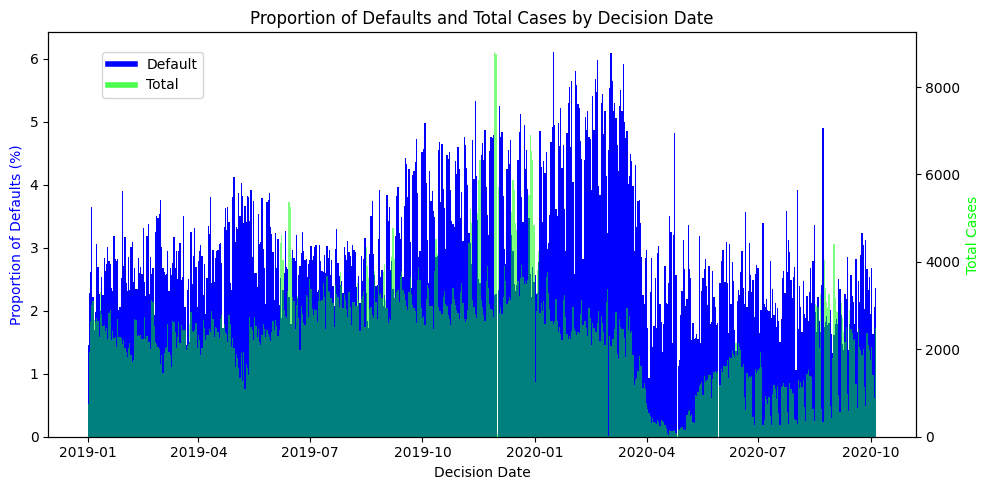

In [5]:
# Get proportion of defaults by date
date_target_prop = base_df.groupby('date_decision')['target'].value_counts(normalize=True).reset_index()
date_target_prop = date_target_prop[date_target_prop['target'] == 1]
date_target_prop['proportion'] = 100 * date_target_prop['proportion']

# Get number of decisions by date
date_total = base_df.groupby('date_decision')['target'].count().reset_index()

# Plot
viz_tools.two_bars_share_x(df1=date_target_prop, df2=date_total,
                          x_name='date_decision', y1_name='proportion',
                          y2_name='target', x_label='Decision Date',
                          title='Proportion of Defaults and Total Cases by Decision Date',
                          y1_label='Proportion of Defaults (%)',
                          y2_label='Total Cases', l1_label='Default',
                          l2_label='Total')

### Data Tables

We have 16 data tables containing static and transactional data stored as categorical data, numerical data, and dates. These tables are further broken down into 3 different depths.

- Depth 0 tables are indexed by the `case_id` alone and primarily include static data such as date of birth.
- Depth 1 tables are indexed by `case_id` and `num_group1` and contain historical data and possible associated parties.
- Depth 2 tables are index by `case_id`, `num_group1`, and `num_group2` while also containing historical data and possible associated parties.

![Tables](figures/tables.jpg)

Of particular note, when `num_group1` is equal to *0*, the data is directly associated with the current applicant of the loan.

In order to predict by case, we needed to aggregate data by `case_id` in the depth 1 and depth 2 tables.

### Data Preprocessing

We separated the data by the current applicant data and non-current applicant data (`num_group1` is not equal to *0*). From there, we applied multiple different aggregations grouping by `case_id`.

- Categorical: we retrieved the mode and applied both binary encoding to reduce the number of columns (versus one-hot encoding) and frequency encoding, to indicate the frequency of the category.
- Numerical: mean, min, max, median, and sum.
- Date: min, max, and number of distinct dates.

![Aggs](figures/aggs.jpg)

From the aggregated data, we decided to subsample the dataset while weighting the training data for the minority class at a ratio of 10:1.  Additionally, the test set was a holdout of the last cases in the dataset, as stated, in order to get a prediction on *future* cases.

In [6]:
import utils.merge_tools as merge_tools

In [7]:
data_dir = '../data/processed/grouped/new_aggs/'
base_file = '../data/raw/csv_files/train/train_base.csv'

n_cases = 20000

# Merging all data tables to base table
train_set, test_set = merge_tools.merge_n_case_ids(
    n_ids=n_cases,  # Total cases
    data_dir=data_dir,
    path_to_base=base_file,
    target_weight=10,   # Weight for minority class subsampling
    test_size=0.2, 
    random_state=28
)

# Drop redundant columns
drop_cols = ['MONTH', 'WEEK_NUM', 'date_decision_right', 'MONTH_right', 'WEEK_NUM_right', 'target_right']
train_set = train_set.drop(columns=drop_cols)
test_set = test_set.drop(columns=drop_cols)

# Sort cases by decision date in train set
train_set = train_set.sort_values('date_decision')

We have a train/test ratio of 4:1.

In [8]:
print('Size of training set:', len(train_set))
print('Size of testing set:', len(test_set))

Size of training set: 16000
Size of testing set: 4000


In [9]:
pct_null = train_set.isnull().sum().sum() / (len(train_set)*(len(train_set.columns)-1))
print(f'Percentage of missing values in aggregated data: {100*pct_null:.2f}%')

Percentage of missing values in aggregated data: 55.76%


The proportion of classes in the training set:

In [10]:
train_set['target'].value_counts(normalize=True)

target
0    0.765563
1    0.234437
Name: proportion, dtype: float64

The proportion of classes in the testing set:

In [11]:
test_set['target'].value_counts(normalize=True)

target
0    0.97775
1    0.02225
Name: proportion, dtype: float64

### Extra data cleaning

We futher clean the data to be able to feed the previously stated predictors.
 - Boolean Columns:
The boolean columns are filled with False where None is present, and then converted to boolean type using .astype(bool).
- Object Columns:
The object columns, which contain None, True, or False, are replaced with np.nan, 1.0, or 0.0 respectively, and converted to float.

In [12]:
# Convert date_decision to timestamp
train_set['date_decision'] = pd.to_datetime(train_set["date_decision"]).astype('int64') / 10**9
test_set['date_decision'] = pd.to_datetime(test_set["date_decision"]).astype('int64') / 10**9

# Get boolean columns from df_full
bool_columns = train_set.select_dtypes(include=['bool']).columns.tolist()

for col in bool_columns:
    train_set[col] = train_set[col].fillna(False).astype(bool)
    test_set[col] = test_set[col].fillna(False).astype(bool)

# Get object columns from df_full
object_columns = train_set.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    train_set[col] = train_set[col].replace({None: np.nan, True: 1.0, False: 0.0})
    test_set[col] = test_set[col].replace({None: np.nan, True: 1.0, False: 0.0})

## Methods

### Initial Handling of Missing Values

In [13]:
# Create missing value count DataFrame
null_df = train_set.copy()
null_df['total_null'] = train_set.isna().sum(axis=1)
null_df = null_df[['target', 'total_null']]

n_bins = 10

# Bin values by total missing values in row
null_df['null_bin'] = pd.cut(null_df['total_null'], bins=n_bins)

# Determine percentage of defaults by missing values in row (bins)
total_counts = null_df.groupby('null_bin')['target'].count().reset_index()
default_counts = null_df.groupby('null_bin')['target'].sum().reset_index()
default_counts['pct'] = [ i/j * 100 for i,j in zip(default_counts['target'], total_counts['target']) ]

With roughly 50% of values still missing in the dataset, we can see that the number of missing values by row has an influence on how likely a case will default. Fewer missing values appeared to indicate a greater likelihood of defaulting.

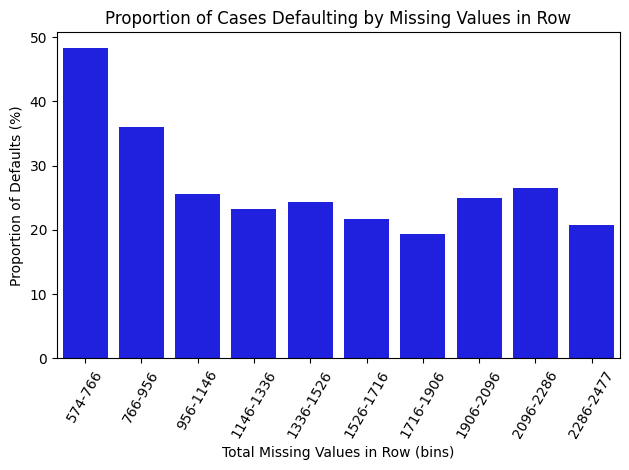

In [14]:
sns.barplot(data=default_counts, x='null_bin', y='pct', color='blue')

# Remove decimals in xticks
bins_list = default_counts['null_bin'].unique().tolist()
x_tick_labels = [ f'{int(cat.left)}-{int(cat.right)}' for cat in bins_list ]

plt.xticks(ticks=range(n_bins), labels=x_tick_labels, rotation=60)
plt.xlabel('Total Missing Values in Row (bins)')
plt.ylabel('Proportion of Defaults (%)')
plt.title('Proportion of Cases Defaulting by Missing Values in Row')
plt.tight_layout()
plt.show()

# Save memory
del null_df

#### Removing Columns where Missing data is more than 95% 

We remove columns with over 95% missing data as due to our train-validation-test split, missing value imputation will nearly be impossible on extremely sparse columns as long runs of missing values on cases may lead to the training data to having columns which contain all null values.

In [15]:
# Train and validation data
val_prop = 0.3
val_size = int(len(train_set) * val_prop)
train_size = len(train_set) - val_size
train_df = train_set.iloc[:train_size].copy()
valid_df = train_set.iloc[-val_size:].copy()

# Remove columns with more than 95% missing values
missing_threshold = 0.95
train_df = train_df[train_df.columns[train_df.isnull().mean() < missing_threshold]]

# Remove columns from validation and test
valid_df = valid_df[train_df.columns]
test_df = test_set[train_df.columns].copy()

In [16]:
# Create X and y
X_train = train_df.drop(columns=['case_id', 'target'])
X_valid = valid_df.drop(columns=['case_id', 'target'])
X_test = test_df.drop(columns=['case_id', 'target'])
y_train = train_df['target']
y_valid = valid_df['target']
y_test = test_df['target']

### Basic and Baseline Model Analysis

Create a Random Model: This model will predict the target label based solely on the average percentage distribution of classes in the entire dataset.

Build Baseline Models: Using the initially pre-processed data and missing values mean imputation, we will construct three baseline models:

Logistic Regression
Decision Tree
LightGBM
Objective

The goal of this exercise is to establish baseline performance metrics, allowing us to compare these initial models with future models that incorporate more advanced transformations and methods. This comparison will help us determine if further enhancements lead to statistically significant improvements in accuracy and model stability.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

### Basic Model Predictor based on target percentage - Weighted Random Chance

In [18]:
# Calculate the percentage of target = 1 in df_full
percentage_target_1 = 3
print(f"Percentage of target = 1: {percentage_target_1:.2f}%")


def model_percentage(data, percentage):
    random_numbers = np.random.rand(len(data))
    predictions = (random_numbers < (percentage / 100)).astype(int)
    return predictions

Percentage of target = 1: 3.00%


### Score Metrics Basic Model

We hardcode the target positive class average to 3% which comes from the complete dataset. 

In [19]:
# Apply the model to base_valid
y_valid_pred = model_percentage(X_valid, percentage_target_1)

# Evaluate the model
auc_score = roc_auc_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
accuracy = accuracy_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)

# Print the evaluation metrics
print(f"AUC: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

AUC: 0.5016
Precision: 0.2635
Recall: 0.0332
Accuracy: 0.7408
F1 Score: 0.0590


The AUC score reflects the model's ability to distinguish between classes. A score closer to 0.5 indicates that the model performs no better than random guessing. Given that this is a random model based on the target's percentage, an AUC score near 0.5 is expected and confirms the model's lack of discriminatory power.

Precision measures the proportion of true positives among all positive predictions. For a random model, precision is typically low as it doesn't have any mechanism to prioritize true positives over false positives.

Recall measures the proportion of actual positives that are correctly identified by the model. A random model's recall is generally proportional to the actual prevalence of the positive class in the dataset. 

Accuracy measures the proportion of all correct predictions (both true positives and true negatives) out of the total predictions. For a random model, the accuracy is influenced by the class distribution in the dataset. An accuracy score that is close to the proportion of the majority class indicates that the model might be leaning towards predicting the majority class more often.

The F1 score is the harmonic mean of precision and recall, providing a balance between the two. We see for this model that is low, reflecting the trade-off between precision and recall when there is no specific pattern in the predictions.

In [20]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    def safe_roc_auc_score(y_true, y_score):
        """ Compute ROC AUC score only if there are two unique values in y_true """
        if len(set(y_true)) < 2:
            return 0 
        else:
            return roc_auc_score(y_true, y_score)

    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2 * safe_roc_auc_score(x["target"], x["score"]) - 1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

#### Stability Basic Model

In [21]:
# Maintain a DataFrame for comparisons
base_train = base_df.iloc[train_df.index]
base_valid = base_df.iloc[valid_df.index]
base_test = base_df.iloc[test_df.index]

for base, X in [(base_train, X_train), (base_valid, X_valid)]:
    y_pred = model_percentage(X, percentage_target_1)
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train:.4f}') 
print(f'The stability score on the valid set is: {stability_score_valid:.4f}') 

The stability score on the train set is: -1.3319
The stability score on the valid set is: -0.0359


### Baseline Model

A more sofisticated Baseline we could use would be to train a Logistic Regressor, Decision Tree Classifier or LGBM Classier on their respective default parameters, which are pre-tuned to work reasonably well for a wide range of datasets. Moreover, we will use a simple mean imputer to handle the missing data. With in our use case is 92%. 

In [22]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)

In [23]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=1),
    "Decision Tree": DecisionTreeClassifier(random_state=1),
    "LightGBM": LGBMClassifier(random_state=1, verbose=-1)
}

# Function to evaluate and print metrics
def evaluate_model(name, y_true, y_pred, y_pred_probs):
    auc_score = roc_auc_score(y_true, y_pred_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

# Iterate through models
for name, model in models.items():
    # Fit the model
    model.fit(X_train_imputed, y_train)
    
    # Predict probabilities and classes
    y_valid_pred_probs = model.predict_proba(X_valid_imputed)[:, 1]
    y_valid_pred = model.predict(X_valid_imputed)
    
    # Evaluate the model
    evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)

    for base, X in [(base_train, X_train_imputed), (base_valid, X_valid_imputed)]:
        y_pred = model.predict_proba(X)[:, 1]
        base["score"] = y_pred
    
    stability_score_train = gini_stability(base_train)
    stability_score_valid = gini_stability(base_valid)

    print(f'The stability score on the train set is: {stability_score_train:.4f}') 
    print(f'The stability score on the valid set is: {stability_score_valid:.4f}') 

--- Logistic Regression ---
AUC: 0.5979
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.7554
F1 Score: 0.0000

The stability score on the train set is: -1.1281
The stability score on the valid set is: -0.1997
--- Decision Tree ---
AUC: 0.5753
Precision: 0.3223
Recall: 0.4719
Accuracy: 0.6281
F1 Score: 0.3830

The stability score on the train set is: -1.6969
The stability score on the valid set is: -0.3348
--- LightGBM ---
AUC: 0.7932
Precision: 0.5628
Recall: 0.4736
Accuracy: 0.7812
F1 Score: 0.5143

The stability score on the train set is: -1.9394
The stability score on the valid set is: -0.0769


Baselines Model Performance Overview
- Logistic Regression
  - Auc: 0.5778 - Slightly better than random guessing (AUC of 0.5). Indicates poor discriminatory power.
  - Precision: 0.0000 - Model did not predict any positives, reflects difficulty in handling class imbalance.
  - Recall: 0.0000 - Model failed to capture any true positives.Indicates that the model is biased towards predicting the majority class (negative).
  - Accuracy: 0.8539 - High accuracy, but misleading due to class imbalance.
  - -0.0531 gini score indicates that the model's predictions are no better than random chance.

**Logistic Regression struggles with the imbalanced dataset, failing to predict the minority class, resulting in poor performance across all metrics except accuracy (missleading due to class imbalance).**

- Decision Tree
  - AUC: 0.5790 - Slightly better than Logistic Regression. Shows moderately more discriminatory power.
  - Precision: 0.2530 - Indicates some ability to correctly predict positive cases.Affected by class imbalance.
  - Recall: 0.3194 - Much better at capturing true positives than Logistic Regression. Reflects some sensitivity to the minority class.
  - Accuracy: 0.7628 - Lower than Logistic Regression, but this is due to better handling of positive (default) cases.
  - F1 Score: 0.2824 - Better balance between precision and recall.
  - -0.5865 gini score indicates that the model's predictions are no better than random chance.

**The Decision Tree shows improved handling of the minority class compared to Logistic Regression, with better precision, recall, and F1 score, though it still struggles with the class imbalance.**

- LightGBM
  - AUC: 0.7942 - Significantly better than Logistic Regression and Decision Tree.
  - Precision: 0.4904 - Highest precision among the models. Better at correctly predicting positive cases.
  - Recall: 0.1464 - Lower recall, indicating some challenges in capturing all true positives. Reflects trade-off between precision and recall.
  - Accuracy: 0.8531 - High accuracy, though influenced by class imbalance.
  - F1 Score: 0.2255 - Reflects better  performance in handling the imbalanced dataset.
  - The stability score on the valid set is -0.0291 which is no better than random chance but we see a slight improve. 

**LightGBM outperforms the other models, especially in terms of AUC and precision, demonstrating better handling of the imbalanced dataset. The model’s ability to auto-tune parameters and handle missing data contributes to its superior performance.**

### Comparison of LightGBM Performance: Mean Imputation vs. Handling Missing Values Directly

Finally, let's check how LightGBM performs with the preprocessed data with the missing values, instead of the mean impute.

The lightGBM model accounts with a handling of missing values build in. It treats missing values as a separate category so:

- Split Finding with Missing Values: Missing Value as a Separate Category: LightGBM treats missing values as a separate category when finding splits. During training, it can decide whether to assign missing values to the left or right side of a split.
- Optimal Split Decision: LightGBM evaluates the best way to handle missing values by considering them during the split-finding process. This means it optimally decides where to place missing values to minimize the loss function.

Reference: LightGBM's official documentation: LightGBM Handling Missing Values. https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle

In [24]:
model = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model.fit(X_train, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model.predict_proba(X_valid)[:, 1]
y_valid_pred = model.predict(X_valid)

# Evaluate the model
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)
for base, X in [(base_train, X_train_imputed), (base_valid, X_valid_imputed)]:
        y_pred = model.predict_proba(X)[:, 1]
        base["score"] = y_pred
stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train:.4f}') 
print(f'The stability score on the valid set is: {stability_score_valid:.4f}')

--- LightGBM ---
AUC: 0.7968
Precision: 0.5582
Recall: 0.4327
Accuracy: 0.7775
F1 Score: 0.4875

The stability score on the train set is: -1.4771
The stability score on the valid set is: -0.0638


A roughly the same as with mean imputation.

### Missing Value Imputation Strategies

1. KNN Imputation:

We will employ KNN imputation, which predicts missing values using the mean or median of the k-nearest neighbors found in the training set. Two configurations will be tested:
    - 5 Neighbors: A tighter cluster which may capture more localized data patterns.
    - 10 Neighbors: A broader cluster to generalize better over the input space.

2. Binary Flag for Missing Values:

Alongside numerical imputation, we will add a binary indicator (flag) for each feature to signal the presence of an imputation. This method helps the model identify patterns associated with the occurrence of missing data.

3. Mean and Median Imputer:

These are straightforward approaches where missing values are replaced with the mean or median of the respective feature. The mean is sensitive to outliers, whereas the median provides a more robust estimate in such cases.

#### Visualization and Evaluation:
1. t-SNE Visualization:

Post-imputation, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize the dataset. This technique will help us observe any distinct patterns or clusters that emerge after imputation, providing insights into how different strategies group the data.

In [25]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

1. KNN Imputation:

In [26]:
# # Fit KNN imputer on training data
# knn_imputer = KNNImputer(n_neighbors=5)
# X_train_knn_imputed_5 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# # Apply KNN imputer to validation data
# X_valid_knn_imputed_5 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

In [27]:
# # Fit KNN imputer on training data
# knn_imputer = KNNImputer(n_neighbors=10)
# X_train_knn_imputed_10 = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# # Apply KNN imputer to validation data
# X_valid_knn_imputed_10 = pd.DataFrame(knn_imputer.transform(X_valid), columns=X_valid.columns)

2. Imputation: Median and Binary flag Indicator for missing values.

In [28]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed = X_train.copy()
X_valid_imputed = X_valid.copy()
X_test_imputed = X_test.copy()

# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed[col + '_missing'] = X_train_imputed[col].isna().astype(int)
    X_valid_imputed[col + '_missing'] = X_valid_imputed[col].isna().astype(int)
    X_test_imputed[col + '_missing'] = X_test_imputed[col].isnull().astype(int)

# Impute missing values with median
median_imputer = SimpleImputer(strategy='median')
X_train_imputed[numerical_columns] = median_imputer.fit_transform(X_train_imputed[numerical_columns])
X_valid_imputed[numerical_columns] = median_imputer.transform(X_valid_imputed[numerical_columns])
X_test_imputed[numerical_columns] = median_imputer.transform(X_test_imputed[numerical_columns])

3. Imputation: Mean and Binary flag Indicator for missing values.

In [29]:
# Identify columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns

X_train_imputed_average = X_train.copy()
X_valid_imputed_average = X_valid.copy()
X_test_imputed_average = X_test.copy()


# Create binary indicator for missing values
for col in numerical_columns:
    X_train_imputed_average[col + '_missing'] = X_train_imputed_average[col].isnull().astype(int)
    X_valid_imputed_average[col + '_missing'] = X_valid_imputed_average[col].isnull().astype(int)
    X_test_imputed_average[col + '_missing'] = X_test_imputed_average[col].isnull().astype(int)

# Impute missing values with median
mean_imputer = SimpleImputer(strategy='mean')
X_train_imputed_average[numerical_columns] = mean_imputer.fit_transform(X_train_imputed_average[numerical_columns])
X_valid_imputed_average[numerical_columns] = mean_imputer.transform(X_valid_imputed_average[numerical_columns])
X_test_imputed_average[numerical_columns] = mean_imputer.transform(X_test_imputed_average[numerical_columns])

#### Proving More Distinct Patterns Post-Imputation visually with t-SNE

To effectively demonstrate the distinct patterns emerging from different imputation strategies, we will utilize t-SNE (t-Distributed Stochastic Neighbor Embedding). This technique is particularly valuable for visualizing high-dimensional data in a lower-dimensional space, typically two dimensions, which makes it easier to identify clusters and separations among data points.

For the first graph, as t-SNE does not inherently accommodate missing values. To prepare our dataset for t-SNE visualization:
For categorical features: Convert NaNs to a unique category, ensuring they are treated distinctly during the dimensionality reduction.
For numerical features: Substitute NaNs with a specific numerical value (e.g., -999). This method marks missing entries distinctly, allowing us to observe how t-SNE handles these values compared to the rest of the dataset.


In [30]:
from sklearn.manifold import TSNE

In [31]:
# Function to preprocess data, handle NaNs, and apply t-SNE
def preprocess_and_tsne_with_nan_handling(X, y, title):
    # Copy the dataset to avoid changing the original
    X_encoded = X.copy()
    
    # Handle NaNs in categorical columns
    for column in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna('NULL')  # Replace NaNs with 'NULL'
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
    
    # Handle NaNs in numerical columns
    for column in X_encoded.select_dtypes(exclude=['object', 'category']).columns:
        X_encoded[column] = X_encoded[column].fillna(-999)  # Replace NaNs with -999
    
    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(X_encoded)
    
    # Create a DataFrame with t-SNE results and target
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['target'] = y.reset_index(drop=True)
    
    # Plot the t-SNE results
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='target',
        palette={0: 'lime', 1: 'blue'},
        data=tsne_df,
        alpha=0.6

    )
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Target')
    plt.grid(True)
    plt.show()

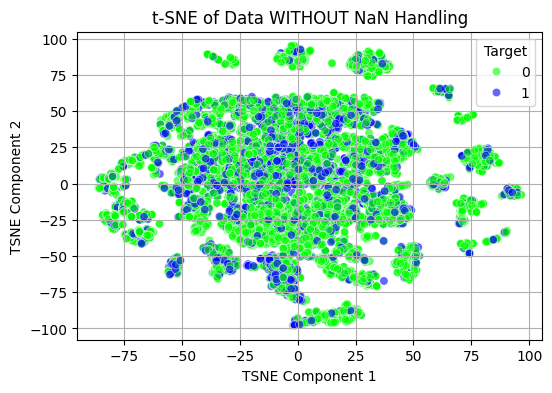

In [32]:
preprocess_and_tsne_with_nan_handling(X_train, y_train, 't-SNE of Data WITHOUT NaN Handling')

In [33]:
# preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_5, y_valid, 't-SNE of NaN Handling with KNN (5) ')

In [34]:
# preprocess_and_tsne_with_nan_handling(X_valid_knn_imputed_10, y_valid, 't-SNE of NaN Handling with KNN (10) ')

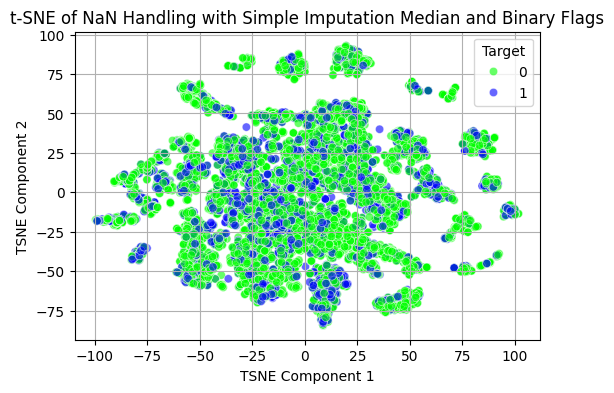

In [35]:
preprocess_and_tsne_with_nan_handling(X_train_imputed, y_train, 't-SNE of NaN Handling with Simple Imputation Median and Binary Flags')

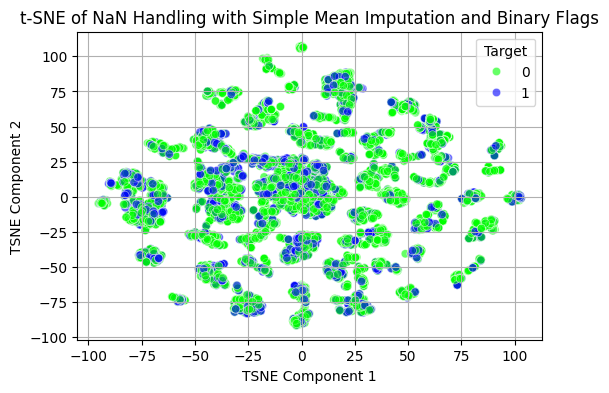

In [36]:
preprocess_and_tsne_with_nan_handling(X_train_imputed_average, y_train, 't-SNE of NaN Handling with Simple Mean Imputation and Binary Flags')

Observation: The visualization reveals more distinct patterns when we implement the Mean Target NaN Imputation method. We will proceed to quantitatively evaluate and compare the performance metrics of this approach in the following section to verify if the observed visual distinctions translate into improved predictive accuracy.

### Post-Imputation Model Evaluation:

Imputed Median Simple Imputer and Numerical Missing Binary Flag

In [37]:
model_median = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_median.fit(X_train_imputed, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_median.predict_proba(X_valid_imputed)[:, 1]
y_valid_pred = model_median.predict(X_valid_imputed)

# Evaluate the model
name = 'lightGBM with NaN Imputer Median Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)
for base, X in [(base_train, X_train_imputed), (base_valid, X_valid_imputed)]:
    y_pred = model_median.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train:.4f}') 
print(f'The stability score on the valid set is: {stability_score_valid:.4f}') 

--- lightGBM with NaN Imputer Median Simple Imputer and Binary Flag ---
AUC: 0.8004
Precision: 0.5766
Recall: 0.4651
Accuracy: 0.7856
F1 Score: 0.5149

The stability score on the train set is: -1.9674
The stability score on the valid set is: -0.3735


In [38]:
model_mean = LGBMClassifier(random_state=1, verbose=-1)
# Fit the model
model_mean.fit(X_train_imputed_average, y_train)

# Predict probabilities and classes
y_valid_pred_probs = model_mean.predict_proba(X_valid_imputed_average)[:, 1]
y_valid_pred = model_mean.predict(X_valid_imputed_average)

# Evaluate the model
name='lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag'
evaluate_model(name, y_valid, y_valid_pred, y_valid_pred_probs)
for base, X in [(base_train, X_train_imputed), (base_valid, X_valid_imputed)]:
    y_pred = model_mean.predict_proba(X)[:, 1]
    base["score"] = y_pred

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)

print(f'The stability score on the train set is: {stability_score_train:.4f}') 
print(f'The stability score on the valid set is: {stability_score_valid:.4f}') 

--- lightGBM with NaN Imputer Mean Simple Imputer and Binary Flag ---
AUC: 0.7998
Precision: 0.5624
Recall: 0.4566
Accuracy: 0.7802
F1 Score: 0.5040

The stability score on the train set is: -1.8697
The stability score on the valid set is: -0.1762


## Evaluation

### Model Performance Evaluation:

Following each imputation method, we will retrain our model and evaluate its performance. Key metrics will include accuracy, F1 score, and AUC-ROC, among others. This step is crucial to determine whether the imputation technique enhances the model’s predictive power or detracts from it.

By systematically implementing and comparing these imputation methods, we aim to identify the strategy that most effectively enhances our model's ability to predict true positives, while addressing the challenges posed by missing values in our dataset.

## Conclusion

## Attribution

## Bibliography

## Appendix